In [1]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical


In [2]:
dataPath='static/dataset_new/train'

In [3]:
def load_images_from_folder(folder):
    images = []
    labels = []
    for label in ["closed", "open", "yawn", "no_yawn"]:
        path = os.path.join(folder, label)
        class_num = ["closed", "open", "yawn", "no_yawn"].index(label)
        for filename in os.listdir(path):
            img = cv2.imread(os.path.join(path, filename))
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Griye çevirme
                img = cv2.resize(img, (64, 64))  # Yeniden boyutlandırma
                images.append(img)
                labels.append(class_num)
    return np.array(images), np.array(labels)


images, labels = load_images_from_folder(dataPath)


In [4]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Verileri normalize etme
X_train = X_train / 255.0
X_test = X_test / 255.0

# Verileri uygun şekle getirme
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

# Verileri kategorik hale getirme
y_train = to_categorical(y_train, 4)
y_test = to_categorical(y_test, 4)


In [18]:
train_datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1
)

train_generator = train_datagen.flow(X_train, y_train, batch_size=32)


In [19]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# EarlyStopping ve ModelCheckpoint callback fonksiyonları
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model4Cat.keras', save_best_only=True)
model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 62, 62, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,625,092 (6.20 MB)

 Trainable params: 1,625,092 (6.20 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
history = model.fit(train_generator, 
                    validation_data=(X_test, y_test), 
                    epochs=50, 
                    callbacks=[early_stopping, model_checkpoint])


Epoch 1/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.7292 - loss: 0.5522 - val_accuracy: 0.8016 - val_loss: 0.4374
Epoch 2/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.7316 - loss: 0.5032 - val_accuracy: 0.8117 - val_loss: 0.3815
Epoch 3/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.7511 - loss: 0.5012 - val_accuracy: 0.7996 - val_loss: 0.3795
Epoch 4/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.7479 - loss: 0.4755 - val_accuracy: 0.7874 - val_loss: 0.4081
Epoch 5/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.7609 - loss: 0.4453 - val_accuracy: 0.8219 - val_loss: 0.3982
Epoch 6/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.7683 - loss: 0.4232 - val_accuracy: 0.7996 - val_loss: 0.3731
Epoch 7/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.7788 - loss: 0.4167 - val_accuracy: 0.8057 - val_loss: 0.3395
Epoch 8/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.8022 - loss: 0.4032 - val_accuracy: 0.8219 - v

In [39]:
model.save('best-model4Cat.h5')

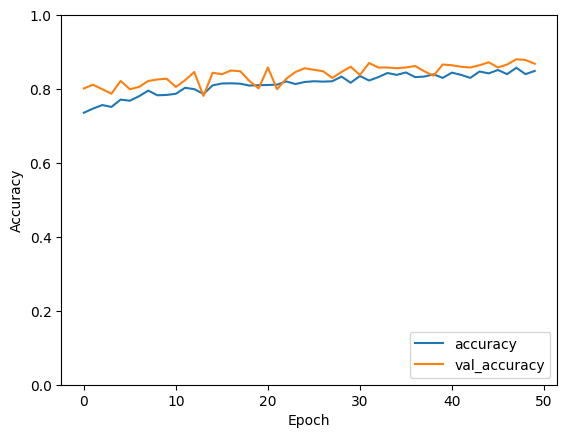

In [22]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()


In [37]:
def predict_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (64, 64))
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    img = np.expand_dims(img, axis=-1)
    
    prediction = model.predict(img)
    class_idx = np.argmax(prediction)
    class_labels = ["closed", "open", "yawn", "no_yawn"]
    return class_labels[class_idx]

example_image_path = dataPath + "/yawn/718.jpg"
print(predict_image(example_image_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
yawn
